# Processing the results of the motif search

In [1]:
import nengo
import multiprocessing
import numpy as np
from itertools import product
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from hashids import Hashids
import cpg_search
reload(cpg_search)
import cpg_search.run_motif_search
reload(cpg_search.run_motif_search)
import cpg_search.utils
reload(cpg_search.utils)
import cpg_search.plotting
reload(cpg_search.plotting)
from cpg_search.run_motif_search import *
from cpg_search.utils import *
from cpg_search.plotting import *
import os
import scipy
from tqdm import tqdm
import networkx as nx
from matplotlib.gridspec import GridSpec
fnpostfix = "2_s0_f_u"
fnpostfix_unf = "2_s0_f"

## Function defs

In [25]:

def draw_graph(metadata,ax2=None,ax1=None, colors=['tab:blue', 'tab:orange']):
    mm = metadata[0]
    lr = metadata[1]
    adj = construct_graph(mm,lr)
    
    
    
    ax2.imshow(adj, aspect='equal')
    ax2.set_xticks([1.75,5.75])
    ax2.set_yticks([1.75,5.75])
    ax2.set_xticklabels(['L','R'])
    ax2.set_yticklabels(['L','R'])
    ax2.axvline([3.5],color='r', ls='--',lw=2)
    ax2.axhline([3.5],color='r', ls='--', lw=2)
#     ax2.grid(which='minor', color='r', linestyle='--', linewidth=1)
    ax2.title.set_text('Generated adjacency matrix')
    
    # Create graph
    G = nx.from_numpy_matrix(adj, create_using=nx.DiGraph)
    # Draw graph
    node_positions = np.array([
        [-2,1.5], # L1
        [-0.5,0], # L2
        [-2.5,-1], # L3
        [-1,-2], # L4
        [2,1.5], # R1
        [0.5,0], # R2
        [2.5,-1], # R3
        [1,-2] # R4
    ])
    node_positions = np.vstack((node_positions, node_positions))
    labels = {
        0: 'L1',
        1: 'L2',
        2: 'L3',
        3: 'L4',
        4: 'R1',
        5: 'R2',
        6: 'R3',
        7: 'R4',
#         8: 'L1',
#         9: 'L2',
#         10: 'L3',
#         11: 'L4',
#         12: 'R1',
#         13: 'R2',
#         14: 'R3',
#         15: 'R4'
    }
    nodecolors = [colors[0]]*4 + [colors[1]]*4
    nx.draw_networkx(G, pos=node_positions,ax=ax1, with_labels=True, labels=labels, node_color=nodecolors )
    ax1.title.set_text("Circuit structure")
def process_fn(top,fn,tslc):
    with open(os.path.join(datapath,fn), 'rb') as fp:
        ret = pickle.load(fp)
    fig = plt.figure(figsize=(16,8))
    gs = GridSpec(2,3)
    
    
    ax = plt.subplot(gs[0,0])
    
    
        
    params = tuple(top.loc[fn,['a','b','c','e']])
    
    refit = lambda x: (np.array(x) - params[-1])/params[0]
    T = ret['time'][tslc]
    x = ret['motor_values'][tslc]
    ax.scatter(T, refit(x), s=0.4)
    cov = top.loc[fn, 'cov']
    err = top.loc[fn,'err']
#     ax.title.set_text("err : {}, params : {}".format(np.round(err,4),np.round(params,2)))
    ax.title.set_text("Decoded motor angle")
    xfit = sin_fit(np.array(ret['time'][tslc]).ravel(), *params)
    ax.plot(T, refit(xfit), color='tab:orange',lw=4, alpha=0.4)
    ax.legend(['Fit','Data'])
    ax.set_ylabel('Value (rescaled)')
    ax.set_xlabel('Time')
    ax = plt.subplot(gs[0,1])
    
    rank =  top.index.get_loc(fn)
    fig.suptitle('Rank {}'.format(rank))
    draw_graph(ret['_metadata'],plt.subplot(gs[0,1]),plt.subplot(gs[0,2]))
    
    ax = plt.subplot(gs[1,:])
    bt = T[0]
    et = T[-1]
    nn = ret['spikes'][0].T.shape[0]
    norder = [0,4,1,5,2,6,3,7]
    im = ax.imshow(ret['spikes'][0].T[norder,tslc], extent=[bt,et,nn,0],aspect='auto')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Neuron')
    ax.set_yticks(np.arange(0.5,nn,1))
    ticks = np.array(['L1','L2','L3','L4','R1','R2','R3','R4'])
    ax.set_yticklabels(ticks[norder])
    cbar = plt.colorbar(im, ax=ax)
    cbar.ax.get_yaxis().labelpad = 15
    cbar.ax.set_ylabel('Firing rate (hz)', rotation=270)
    ax.title.set_text("Firing rate")
    pr = np.round(params,3)
    figfilename = "rank{}_a{}b{}c{}e{}_{fn}.png".format(rank, *pr, fn=fn[:-4])
    print(pr, top.loc[fn, 'fitness'])
    plt.savefig(figfilename, dpi=300 )

## Data load

In [26]:
raw_df = pd.read_pickle('sin_fit_results_df{}.pkl'.format(fnpostfix_unf))
uniques = np.load('uniques{}.npy'.format(fnpostfix))
datapath = './data_s0_f'
tslc = slice(3000,4000)
# tslc = slice(0,None)

## Apply filters

In [23]:
# Filter out small amplitude waves -- usually means that there was no output
df = raw_df.copy()
df = df.loc[uniques,:]
df = df.query("abs(a) >= 1e-2")
# Filter out super low frequency waves -- usually bad fit
df = df.query("b > 2")
len(df)

45187

## Evaluate fitness function on parameters and error

In [24]:
df['fitness'] = df.apply(lambda r: r.err/np.abs(r.a), axis=1)
# df['fitness'] = df.apply(lambda r: r.a, axis=1)
# df['fitness'] = df['err']


In [19]:
fit_sorted = df.sort_values(by='fitness')
top = fit_sorted.head()


## Top performers

(array([ 0.463, 24.007,  2.528, -1.   ]), 9.820323563385474)
(array([-0.463, 24.03 ,  3.32 , -1.   ]), 10.161478257930693)
(array([-0.463, 24.03 ,  3.32 , -1.   ]), 10.161478257930693)
(array([-0.463, 24.03 ,  3.32 , -1.   ]), 10.161478257930693)
(array([-0.463, 24.03 ,  3.32 , -1.   ]), 10.161478257930693)


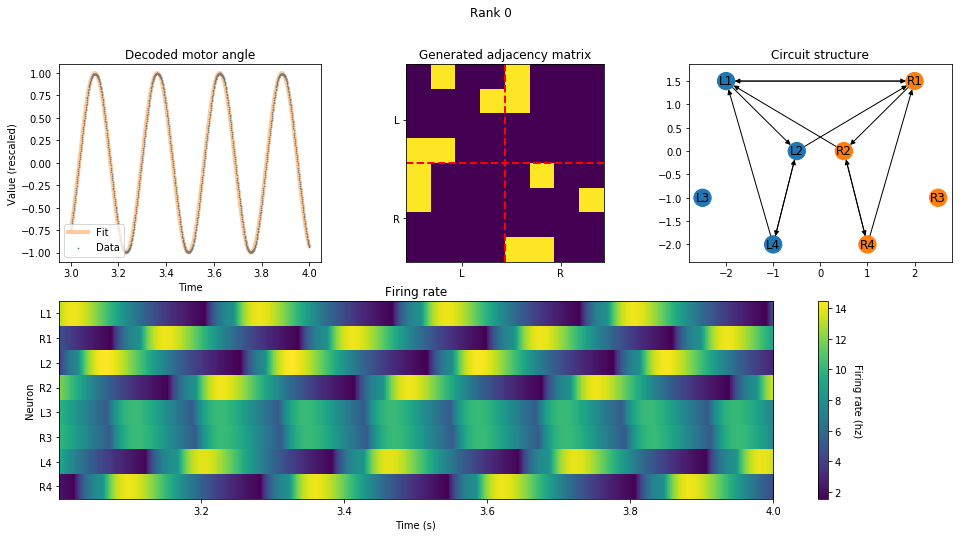

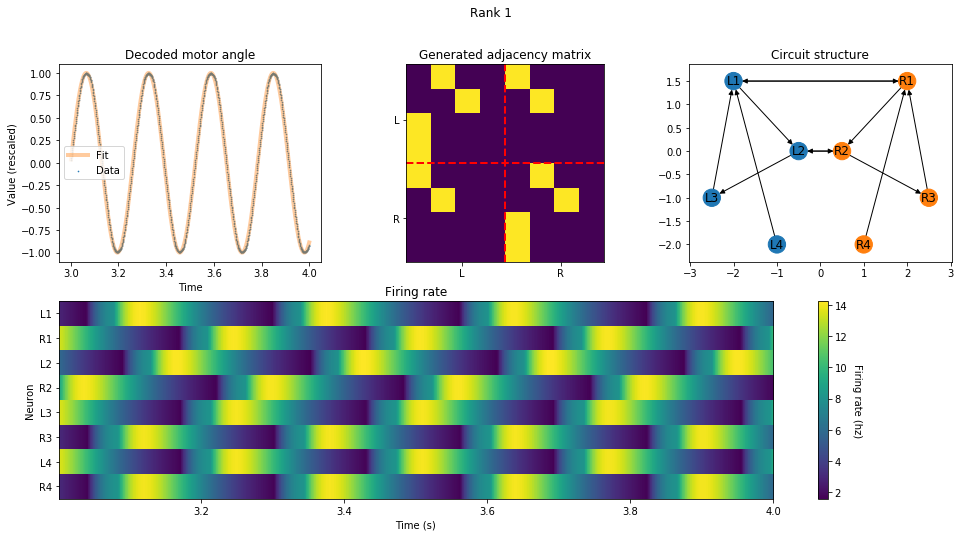

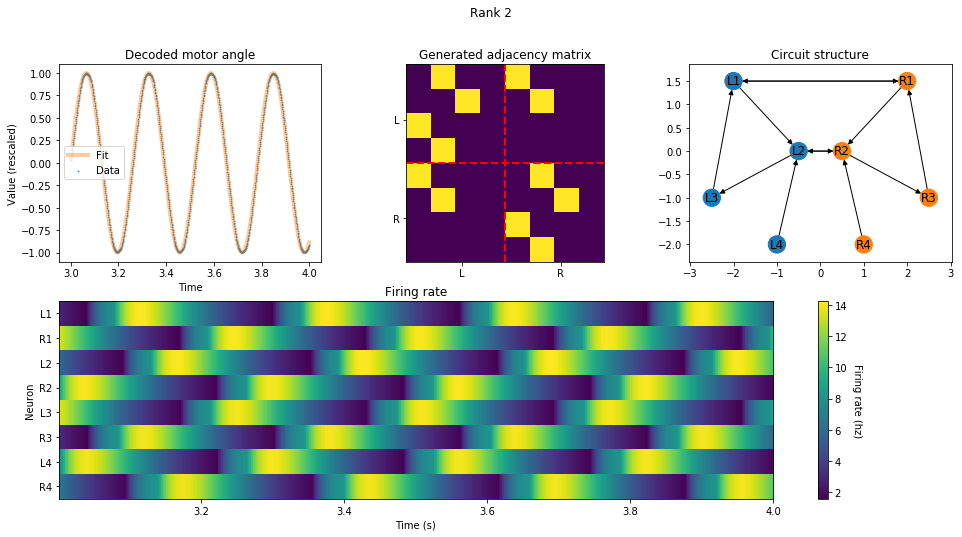

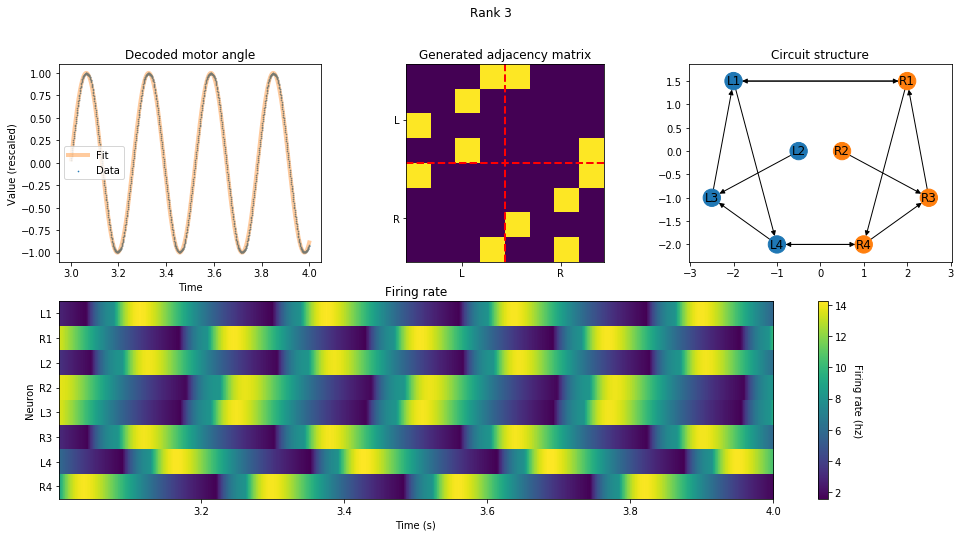

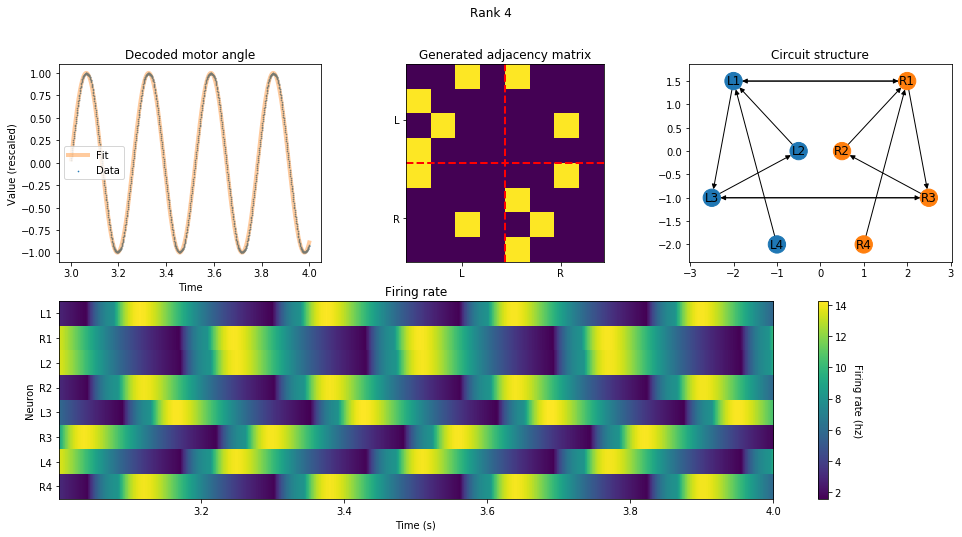

In [20]:
for i,fn in enumerate(top.index):
    process_fn(top,fn,tslc)

False

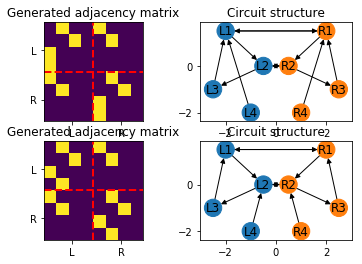

In [29]:
with open(os.path.join(datapath,top.index[1]), 'rb') as fp:
    ret1 = pickle.load(fp)
adj1 = construct_graph(*ret1['_metadata'])
G1 = nx.from_numpy_matrix(adj1, create_using=nx.DiGraph)

with open(os.path.join(datapath,top.index[2]), 'rb') as fp:
    ret2 = pickle.load(fp)
adj2 = construct_graph(*ret2['_metadata'])
G2 = nx.from_numpy_matrix(adj2, create_using=nx.DiGraph)

fig, ax = plt.subplots(2,2)
draw_graph(ret1['_metadata'], ax[0,0], ax[0,1])
draw_graph(ret2['_metadata'], ax[1,0], ax[1,1])
nx.algorithms.isomorphism.is_isomorphic(G1,G2)

# Check biological networks

## Leech heartbeat

(array([-0.911, 16.111,  8.386, -0.445]), 26.97260510062412)
err                                                  24.5629
cov        [[[1.7418007726158567e-06, -3.5836726515716075...
a                                                  -0.910662
b                                                    16.1105
c                                                    8.38573
e                                                  -0.444613
fitness                                              27.9726
Name: oRcLcZcqfYfQcWcqcDcofqcXcOcncxfZcgfLc7cocrcpcVc8cRc1cWfjcQc7c6cE.pkl, dtype: object


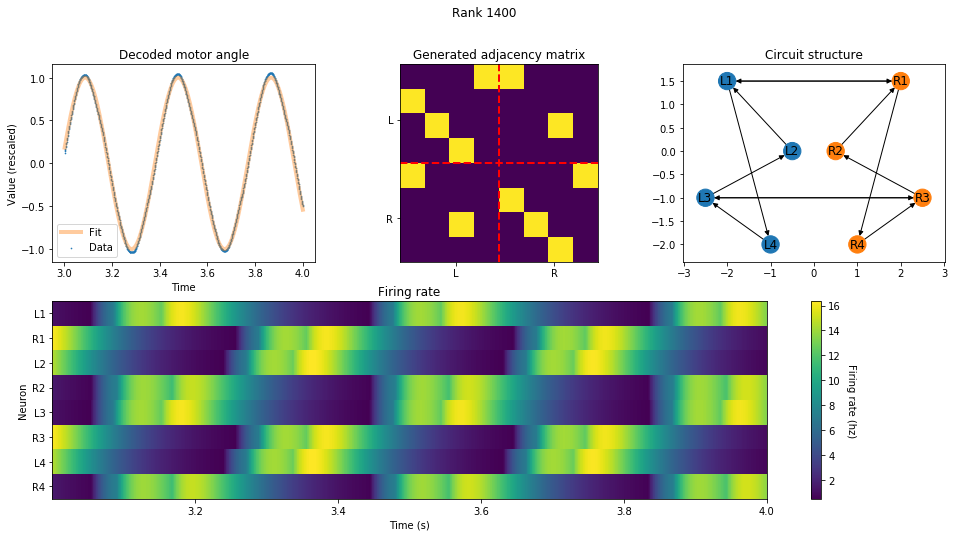

In [30]:
mm = np.array(
[
    [0,0,0,1],
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,0]
])
lr = np.array(
[
    [1,0,0,0],
    [0,0,0,0],
    [0,0,1,0],
    [0,0,0,0]
])

fn = make_hash((mm,lr)) + '.pkl'
process_fn(fit_sorted,fn,tslc)
fit_sorted.loc[fn, 'fitness'] = fit_sorted.loc[fn, 'fitness'] + 1
print(fit_sorted.loc[fn,:])

## Proposed heartbeat

In [ ]:
mm = np.array(
[
    [0,1,0,0],
    [0,0,0,0],
    [0,0,0,0],
    [0,0,0,0]
])
lr = np.array(
[
    [1,0,0,0],
    [0,0,0,0],
    [0,0,0,0],
    [0,0,0,0]
])

fn = make_hash((mm,lr)) + '.pkl'
process_fn(fit_sorted,fn)
fit_sorted.loc[fn, 'fitness'] = fit_sorted.loc[fn, 'fitness'] + 1

## C. elegans

In [ ]:
mm = np.array(
[
    [0,1,1,0],
    [0,0,0,0],
    [0,1,0,0],
    [0,0,0,0]
])
lr = np.array(
[
    [0,0,1,0],
    [0,0,0,0],
    [0,0,0,0],
    [0,0,0,0]
])

fn = make_hash((mm,lr)) + '.pkl'
process_fn(raw_df,fn)

## Check where fitness starts to increase

(array([-0.454, 16.444,  8.236, -0.494]), 60.706597031611196)
(array([-0.454, 16.444,  8.236, -0.494]), 60.706597031611196)


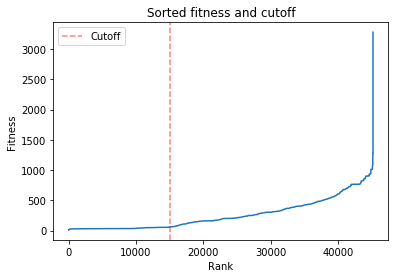

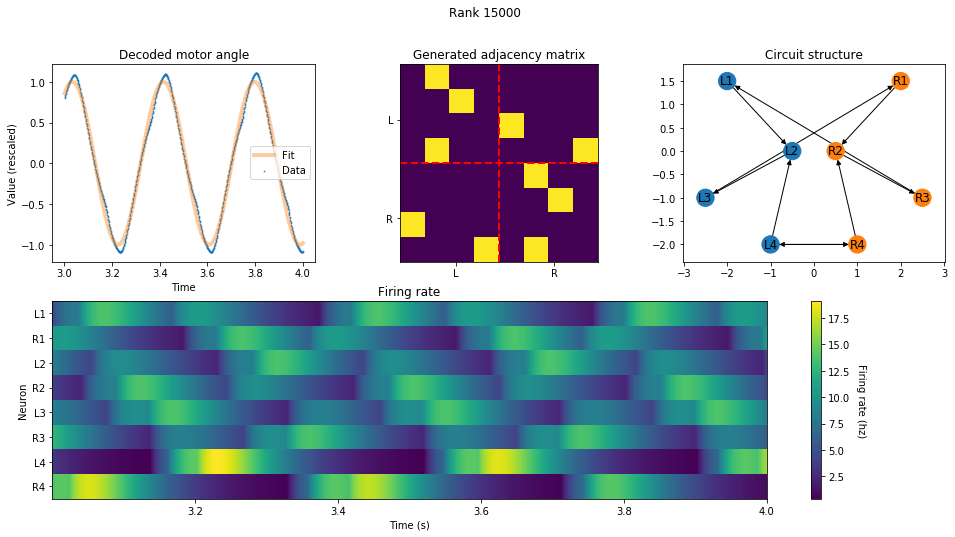

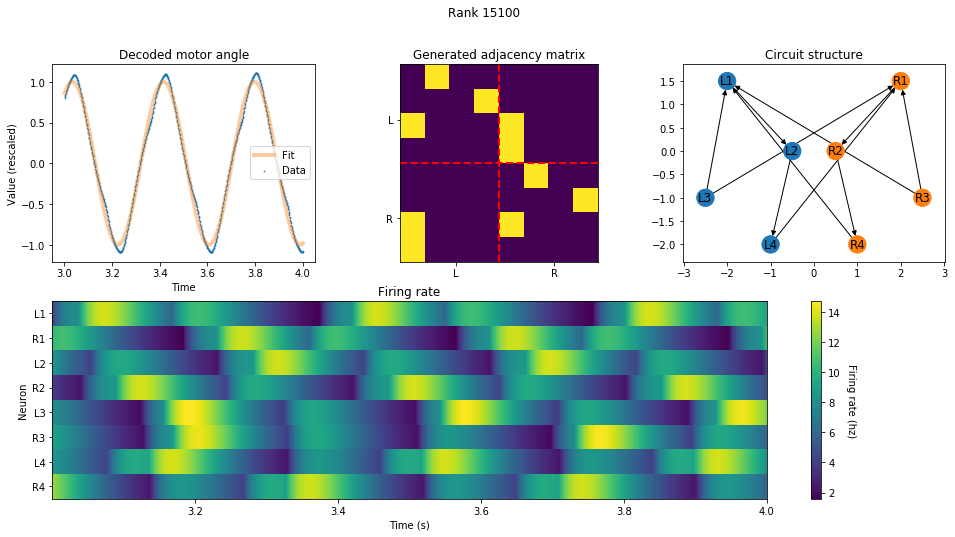

In [32]:
fig, ax = plt.subplots()
ax.plot(fit_sorted['fitness'].to_numpy())
ebreak_idx = 15000
l = ax.axvline(ebreak_idx, ls='--', color='r', alpha=0.5)
ax.set_xlabel('Rank')
ax.set_ylabel('Fitness')
ax.legend([l],['Cutoff'])
ax.title.set_text('Sorted fitness and cutoff')
process_fn(fit_sorted,fit_sorted.iloc[ebreak_idx].name,tslc=tslc)
process_fn(fit_sorted,fit_sorted.iloc[ebreak_idx+100].name,tslc=tslc)

In [34]:
top_n = 100
top = fit_sorted.sort_values(by='fitness').head(top_n)
def add_metadata(idx):
    with open(os.path.join(datapath,idx), 'rb') as fp:
        ret = pickle.load(fp)
    return [ret['_metadata']]
top['_metadata'] = top.index.map(add_metadata)

top.to_pickle('top_sin_fit_{}_{}'.format(top_n,fnpostfix))

In [ ]:
top